# Characterizing the Hypergraph-of-Entity with TF-Bins

This representation model uses a weighted mixed hypergraph. Dependending on the version, the weights can be unitary constants. All versions combine directed and undirected hyperedges.

Possible node classes include:

- TermNode
- EntityNode

Possible hyperedge classes include:

- DocumentEdge
- ContainedInEdge
- RelatedToEdge
- SynonymEdge
- ContextEdge

In order to run the notebook, you must first obtain the corresponding CSV files through the `inspect` command in Army ANT. For example:

```bash
./army-ant.py inspect \
    --index-location=/opt/army-ant/indexes/inex-2009-10t-nl/hgoe \
    --index-type=hgoe \
    --workdir=/opt/army-ant/analysis/inex_2009_10t_nl-stats \
    --feature=export-node-degrees
```

You must then put the resulting files into the `data` directory for the collection and index version. For example `data/inex_2009_10t_nl/base_model` for the Hypergraph-of-Entity Base Model over the INEX 2009 3T-NL subset test collection. You should then configure the `base_dir` below accordingly. Bash scripts are provided in directory `runs/inex-2009-10t-nl/hgoe/nb-characterization`, in order to generate the required files.

In [237]:
if (!require("pacman")) install.packages("pacman")

pacman::p_load(
    tidyverse,
    logging,
    scales,
    repr,
    stringr,
    xtable
)

basicConfig()
options(warn=-1)
options(scipen=0)
options(xtable.include.rownames=FALSE)

base_dir <- "data/inex_2009_10t_nl/tf_bins"

## Node degree and hyperedge cardinality distributions

We define a degree data loading function for a given `base_dir`, beautifying the node and hyperedge type labels (i.e., transforming from the Java class identifier to the node or hyperedge label used in the theory).

In [261]:
load_node_degree_data <- function(base_dir) {
    nodes_path <- file.path(base_dir, list.files(path = base_dir, pattern = "node-degree-.*\\.csv"))

    nodes <- setNames(
        read.csv(nodes_path, stringsAsFactors = F),
        c("node_id", "type", "name", "v_degree", "e_degree", "in_v_degree", "out_v_degree",
          "in_e_degree", "out_e_degree", "dir_in_v_degree", "dir_out_v_degree",
          "dir_in_e_degree", "dir_out_e_degree"))
    
    nodes[which(nodes$type == "EntityNode"), "type"] <- "entity"
    nodes[which(nodes$type == "TermNode"), "type"] <- "term"
 
    nodes
}

load_edge_cardinality_data <- function(base_dir) {
    edges_path <- file.path(base_dir, list.files(path = base_dir, pattern = "edge-cardinality-.*\\.csv"))

    edges <- setNames(
        read.csv(edges_path, stringsAsFactors = F),
        c("edge_id", "type", "is_directed", "cardinality", "undirected_cardinality",
          "tail_cardinality", "head_cardinality"))
    
    edges$is_directed <- edges$is_directed == "true"
    
    edges[which(edges$type == "DocumentEdge"), "type"] <- "document"
    edges[which(edges$type == "ContainedInEdge"), "type"] <- "contained_in"
    edges[which(edges$type == "RelatedToEdge"), "type"] <- "related_to"
    edges[which(edges$type == "SynonymEdge"), "type"] <- "synonym"
    edges[which(edges$type == "ContextEdge"), "type"] <- "context"
    edges[which(edges$type == "TFBinEdge"), "type"] <- "tf_bin"
 
    edges
}

A hypergraph has two degree distributions, one for the nodes and another one for the hyperedges. We look at both.

In [262]:
bin_dirs <- list.files(base_dir)

In [263]:
node_degree <- lapply(file.path(base_dir, bin_dirs, "global"), load_node_degree_data)
names(node_degree) <- bin_dirs
node_degree <- do.call(rbind, node_degree)
node_degree$bin_id <- sapply(str_split(row.names(node_degree), "\\."), `[`, 1)
row.names(node_degree) <- NULL

In [264]:
head(node_degree)

node_id,type,name,v_degree,e_degree,in_v_degree,out_v_degree,in_e_degree,out_e_degree,dir_in_v_degree,dir_out_v_degree,dir_in_e_degree,dir_out_e_degree,bin_id
<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
0,entity,Pyotr Ilyich Tchaikovsky,21002,107,21002,21002,107,106,2,0,1,0,bins_02
1,entity,Central Industrial Security Force,1791,5,1791,1791,5,4,1,0,1,0,bins_02
2,entity,Mao Asada,1778,9,1778,1778,9,8,2,0,1,0,bins_02
3,entity,List of people from Saint Petersburg,3659,4,3659,3657,4,3,5,0,1,0,bins_02
4,entity,Mily Balakirev,8232,13,8232,8232,13,12,1,0,1,0,bins_02
5,entity,Ernst Moritz Arndt,3236,5,3236,3236,5,4,3,0,1,0,bins_02


In [265]:
edge_cardinality <- lapply(file.path(base_dir, bin_dirs, "global"), load_edge_cardinality_data)
names(edge_cardinality) <- bin_dirs
edge_cardinality <- do.call(rbind, edge_cardinality)
edge_cardinality$bin_id <- sapply(str_split(row.names(edge_cardinality), "\\."), `[`, 1)
row.names(edge_cardinality) <- NULL

In [266]:
head(edge_cardinality)

edge_id,type,is_directed,cardinality,undirected_cardinality,tail_cardinality,head_cardinality,bin_id
<int>,<chr>,<lgl>,<int>,<int>,<int>,<int>,<chr>
0,document,FALSE,853,853,0,0,bins_02
1,document,FALSE,404,404,0,0,bins_02
2,document,FALSE,364,364,0,0,bins_02
3,document,FALSE,755,755,0,0,bins_02
4,related_to,FALSE,20,20,0,0,bins_02
5,related_to,FALSE,181,181,0,0,bins_02


In [267]:
edge_cardinality %>%
    group_by(type, bin_id) %>%
    summarise(max_cardinality=max(cardinality))

type,bin_id,max_cardinality
<chr>,<chr>,<int>
contained_in,bins_02,16
contained_in,bins_03,16
contained_in,bins_04,16
contained_in,bins_05,16
contained_in,bins_06,16
contained_in,bins_07,16
contained_in,bins_08,16
contained_in,bins_09,16
contained_in,bins_10,16


We define a degree plotting function that takes the raw CSV, calculates the degree frequency and displays a point plot with a facet for each node or hyperedge type.

In [217]:
plot_degree_per_type <- function(data, label, name="degree") {
    data <- data %>%
        count(bin_id, type, !!sym(name), sort=TRUE)
    
    ggplot(data, aes_string(x=name, y="n")) +
        facet_grid(bin_id~type) +
        geom_point(size=0.5) +
        scale_x_log10() + 
        scale_y_log10(limits=c(1,max(data$Freq))) +
        xlab(label) +
        ylab("Frequency")
}

### Node degree distributions

As we can see, the node node degree distribution in the hypergraph-of-entity does not follow a power law, despite having a long tail.

In [195]:
options(repr.plot.width=4.5, repr.plot.height=10)

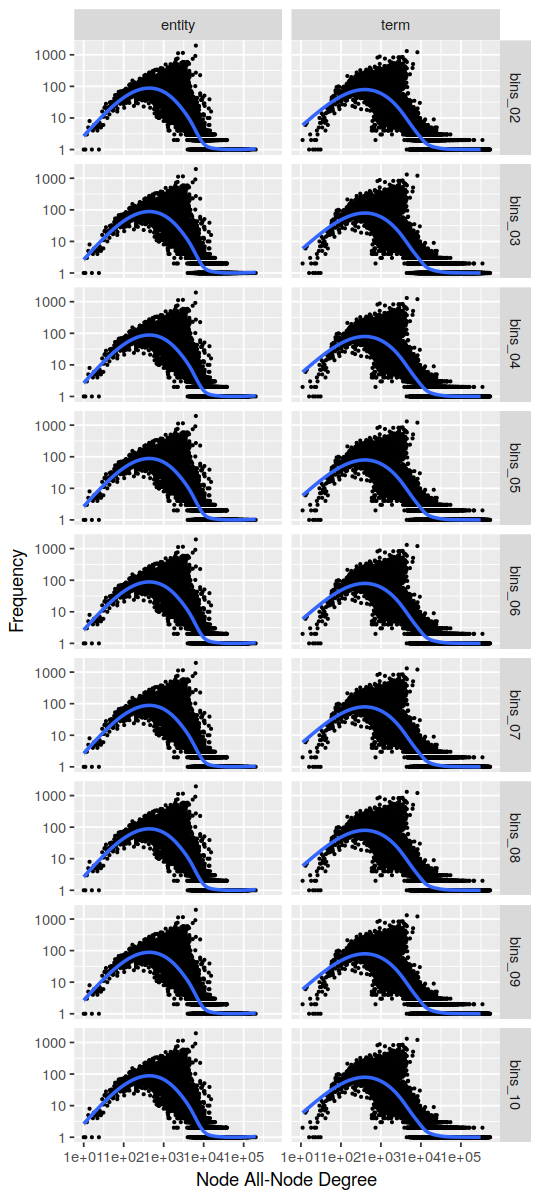

In [187]:
plot_degree_per_type(node_degree, "Node All-Node Degree", "v_degree") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))
ggsave(filename = "output/tf_bins/node_all_node_degree.png", width = 4.5, height = 10, dpi = 300)

However, the hyperedge node degree distribution, slightly approximates a power law.

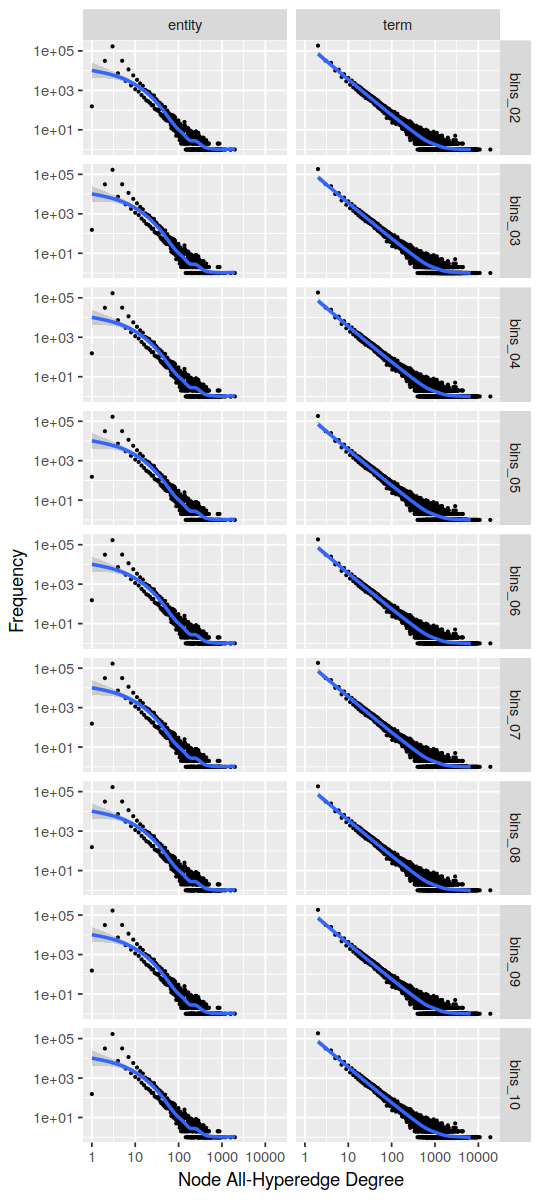

In [188]:
plot_degree_per_type(node_degree, "Node All-Hyperedge Degree", "e_degree") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))
ggsave(filename = "output/tf_bins/node_all_hyperedge_degree.png", width = 4.5, height = 10, dpi = 300)

#### Node degree distributions based on directed hyperedges

If we only consider directed hyperedges, the node incoming-node degree does not follow a power law.

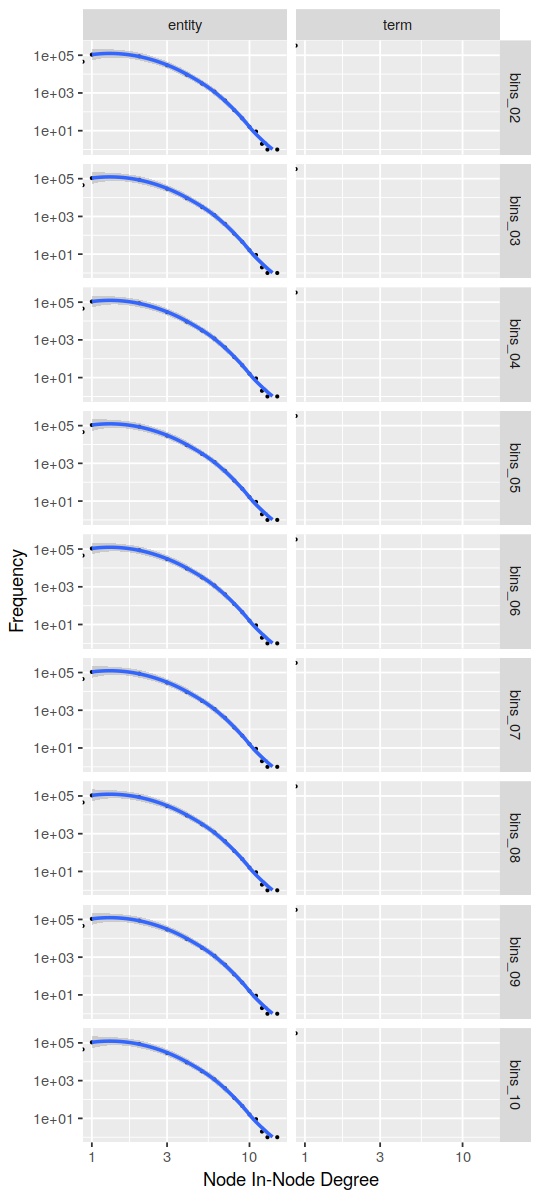

In [196]:
plot_degree_per_type(node_degree[node_degree$type == "entity", ], "Node In-Node Degree", "dir_in_v_degree") +
    stat_smooth(method = "loess")

For directed hyperedges, the node outgoing-node degree approximates a power law, although it is more heavy-tailed.

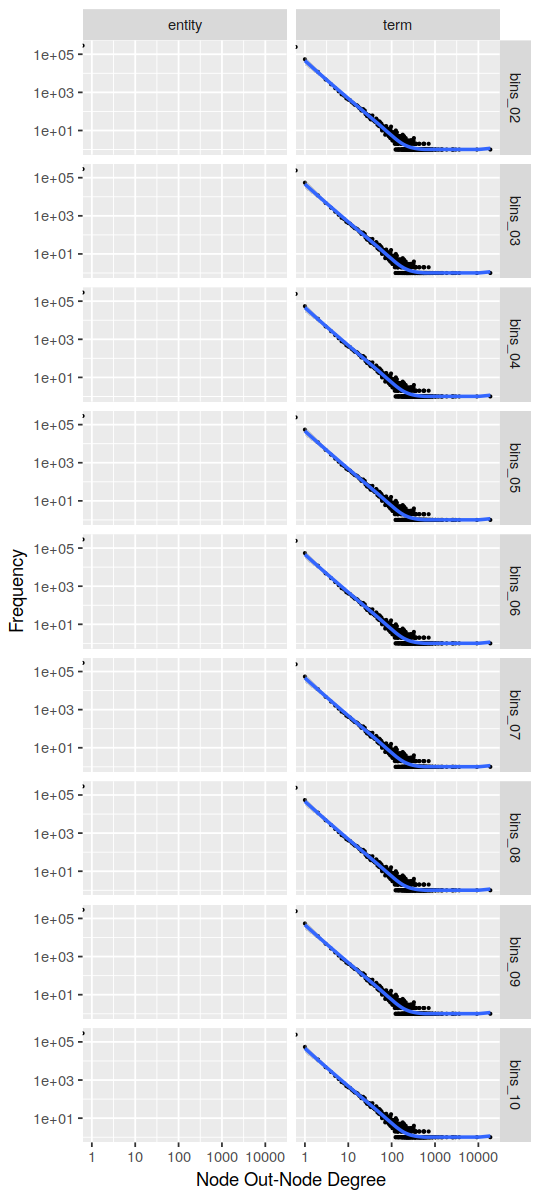

In [197]:
plot_degree_per_type(node_degree[node_degree$type == "term", ], "Node Out-Node Degree", "dir_out_v_degree") +
    stat_smooth(method = "loess")

For directed hyperedges, the node incoming-hyperedge degree is always one.

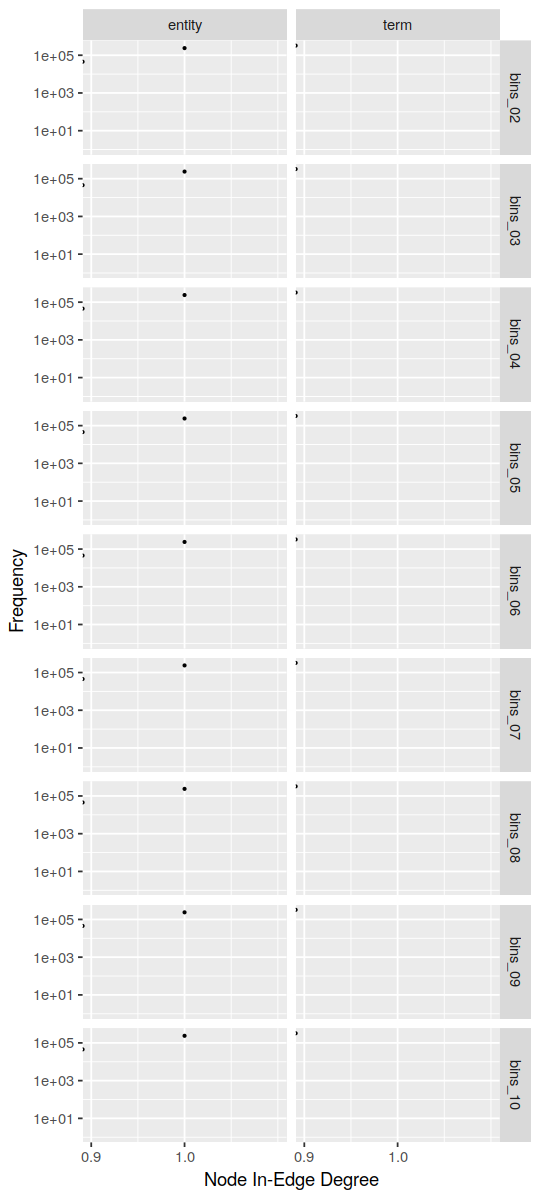

In [198]:
plot_degree_per_type(node_degree[node_degree$type == "entity", ], "Node In-Edge Degree", "dir_in_e_degree") +
    stat_smooth(method = "loess")

For directed hyperedges, the node outgoing-node degree, approximates a power law, although it is more heavy-tailed.

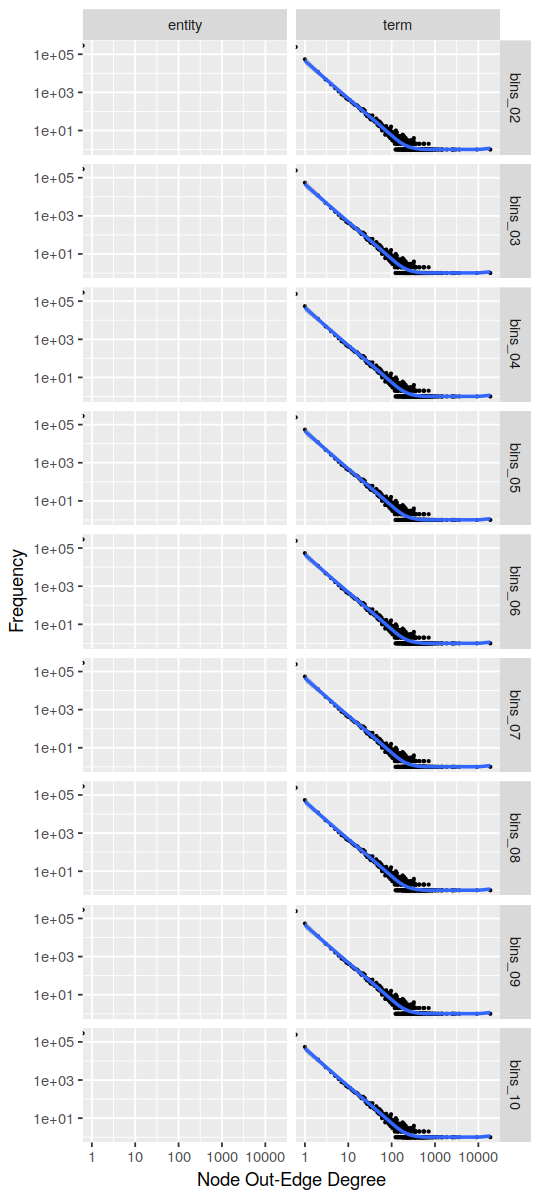

In [199]:
plot_degree_per_type(node_degree[node_degree$type == "term", ], "Node Out-Edge Degree", "dir_out_e_degree") +
    stat_smooth(method = "loess")

### Hyperedge cardinality distributions

The hyperedge cardinality distributions do not follow power laws, with the `contained_in` hyperedges having less nodes than `document` or `related_to` hyperedges. This is expected, as `contained_in` hyperedges usually link a few `term` nodes to its corresponding `entity` node.

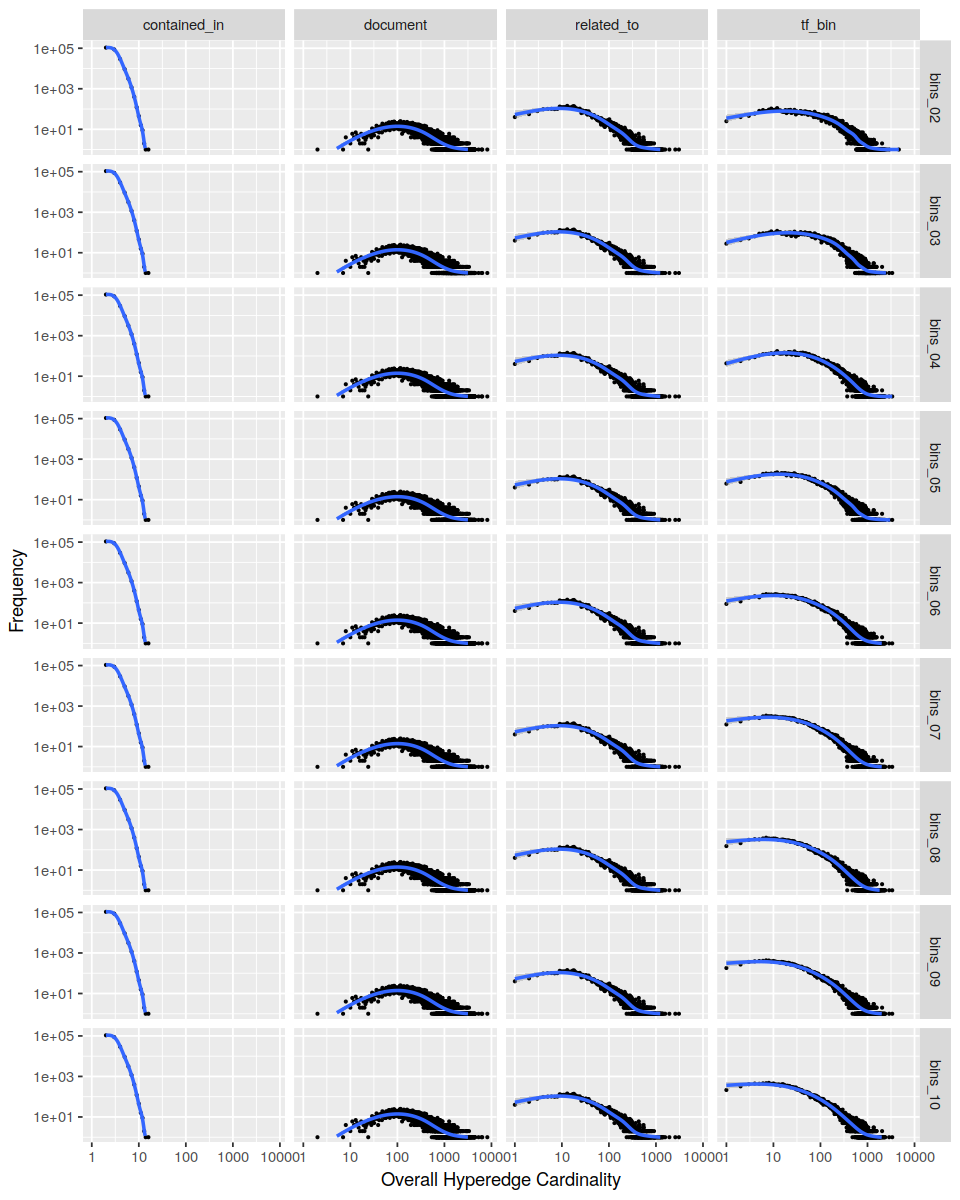

In [219]:
options(repr.plot.width=8, repr.plot.height=10)
plot_degree_per_type(edge_cardinality, "Overall Hyperedge Cardinality", "cardinality") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))
ggsave(filename = "output/tf_bins/hyperedge_overall_cardinality.png", width = 8, height = 10, dpi = 300)

#### Hyperedge cardinality distribution based on directed hyperedges

If we only consider directed hyperedges, the tail cardinality has the following non-power-law distribution.

In [222]:
options(repr.plot.width=3.25, repr.plot.height=10)

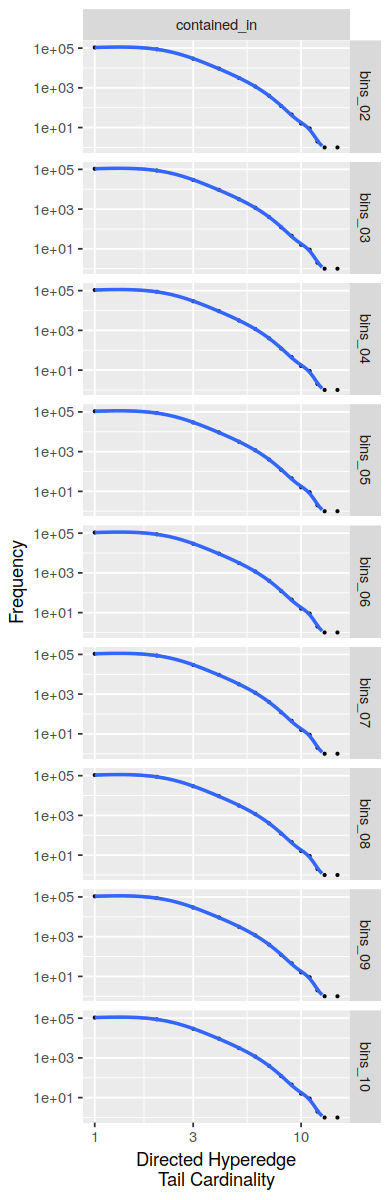

In [223]:
plot_degree_per_type(edge_cardinality[edge_cardinality$type == "contained_in", ],
                     "Directed Hyperedge\nTail Cardinality", "tail_cardinality") +
    #scale_x_continuous() +
    #scale_y_continuous() +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))

For directed hyperedges, the head cardinality is always one.

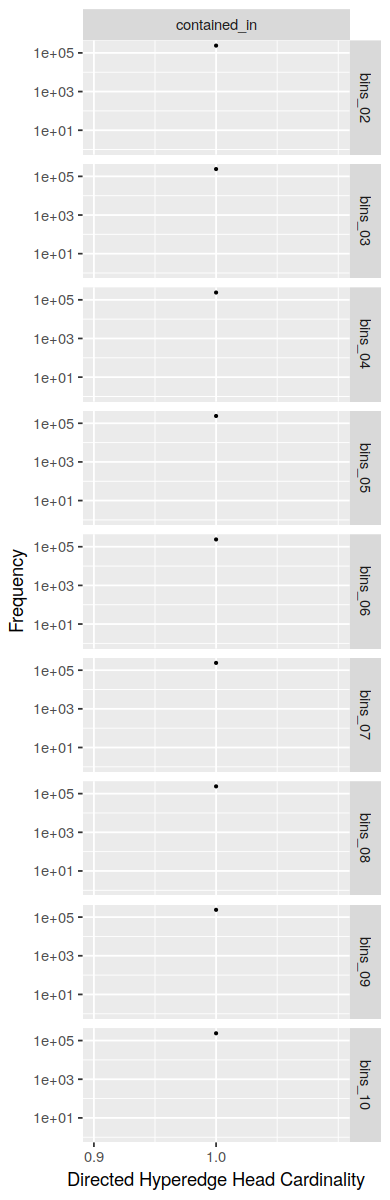

In [224]:
plot_degree_per_type(edge_cardinality[edge_cardinality$type == "contained_in", ],
                     "Directed Hyperedge Head Cardinality", "head_cardinality") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))

## Top 10 nodes

### Node incoming-node degree

In [232]:
top_10_terms_by_incoming_node_degree <- node_degree %>%
    filter(type == "term") %>%
    group_by(bin_id, node_id) %>%
    summarise(name=max(name), in_v_degree=sum(in_v_degree)) %>%
    arrange(bin_id, desc(in_v_degree)) %>%
    group_by(bin_id) %>%
    group_map(~head(.x, 10))
top_10_terms_by_incoming_node_degree

node_id,name,in_v_degree
<int>,<chr>,<int>
458,also,537951
577,new,522929
525,on,512256
770,first,509026
857,time,492091
847,refer,484452
1595,see,482742
762,state,478662
842,link,475903


In [233]:
top_10_entities_by_incoming_node_degree <- node_degree %>%
    filter(type == "entity") %>%
    group_by(bin_id, node_id) %>%
    summarise(name=max(name), in_v_degree=sum(in_v_degree)) %>%
    arrange(bin_id, desc(in_v_degree)) %>%
    group_by(bin_id) %>%
    group_map(~head(.x, 10))
top_10_entities_by_incoming_node_degree

node_id,name,in_v_degree
<int>,<chr>,<int>
2323,United States,199796
300,India,174817
275,Japan,154539
9006,France,146492
4007,2007,136161
8735,World War II,134358
4367,Germany,133949
3992,2006,130566
92,Russia,126066


### Node incoming-hyperedge degree

In [235]:
top_10_terms_by_incoming_hyperedge_degree <- node_degree %>%
    filter(type == "term") %>%
    group_by(bin_id, node_id) %>%
    summarise(name=max(name), in_e_degree=sum(in_e_degree)) %>%
    arrange(desc(in_e_degree)) %>%
    group_by(bin_id) %>%
    group_map(~head(.x, 10))
top_10_terms_by_incoming_hyperedge_degree

node_id,name,in_e_degree
<int>,<chr>,<int>
458,also,10768
847,refer,9400
842,link,9114
841,extern,8928
525,on,8838
577,new,8398
770,first,8186
857,time,8014
1595,see,7992


In [236]:
top_10_entities_by_incoming_hyperedge_degree <- node_degree %>%
    filter(type == "entity") %>%
    group_by(bin_id, node_id) %>%
    summarise(name=max(name), in_e_degree=sum(in_e_degree)) %>%
    arrange(desc(in_e_degree)) %>%
    group_by(bin_id) %>%
    group_map(~head(.x, 10))
top_10_entities_by_incoming_hyperedge_degree

node_id,name,in_e_degree
<int>,<chr>,<int>
2323,United States,1984
4238,Scientific classification,1596
300,India,1587
275,Japan,1205
4216,Dinosaur,1129
4007,2007,1009
3992,2006,1005
9006,France,984
4367,Germany,922


## Global statistics

In [270]:
load_stats_data(file.path(base_dir, "bins_02/global"))

Statistic,Value
<chr>,<dbl>
Vertices,6.072130e+05
Directed Hyperedges,2.382160e+05
Undirected Hyperedges,2.988400e+04
Total Hyperedges,2.681000e+05
Num Sources,0.000000e+00
Num Sinks,0.000000e+00
Density,7.580051e-06
Avg. Degree,8.830509e-01
Min InEdge Degree,1.000000e+00


In [269]:
load_stats_data <- function(base_dir, as_list=FALSE) {
    stats_path <- file.path(base_dir, list.files(path = base_dir, pattern = "stats-.*\\.csv"))

    stats <- read.csv(stats_path, stringsAsFactors = F)
    
    stats
}

In [276]:
compute_other_stats <- function(node_degree, edge_cardinality, bin_id) {
    data.frame(
        Statistic=c(
            "Term Vertices",
            "Entity Vertices",
            "contained_in Hyperedges",
            "document Hyperedges",
            "related_to Hyperedges"
        ),
        Value=c(
            nrow(node_degree[node_degree$type == "term" & node_degree$bin_id == bin_id, ]),
            nrow(node_degree[node_degree$type == "entity" & node_degree$bin_id == bin_id, ]),
            nrow(edge_cardinality[edge_cardinality$type == "contained_in" & edge_cardinality$bin_id == bin_id, ]),
            nrow(edge_cardinality[edge_cardinality$type == "document" & edge_cardinality$bin_id == bin_id, ]),
            nrow(edge_cardinality[edge_cardinality$type == "related_to" & edge_cardinality$bin_id == bin_id, ])
        )
    )
}

In [313]:
stats <- bind_rows(
    lapply(bin_dirs, function(bin_dir) {
        rbind(
            cbind(bin_id=bin_dir, load_stats_data(file.path(base_dir, bin_dir, "global"))),
            cbind(bin_id=bin_dir, compute_other_stats(node_degree, edge_cardinality, bin_dir)))
    })
)
head(stats, 24)

bin_id,Statistic,Value
<chr>,<chr>,<dbl>
bins_02,Vertices,6.072130e+05
bins_02,Directed Hyperedges,2.382160e+05
bins_02,Undirected Hyperedges,2.988400e+04
bins_02,Total Hyperedges,2.681000e+05
bins_02,Num Sources,0.000000e+00
bins_02,Num Sinks,0.000000e+00
bins_02,Density,7.580051e-06
bins_02,Avg. Degree,8.830509e-01
bins_02,Min InEdge Degree,1.000000e+00


In [658]:
plot_stat <- function(stats, stat_name) {
    data <- stats[stats$Statistic == stat_name, ] %>%
        mutate(bins=factor(as.integer(str_split(bin_id, "_", simplify = TRUE)[, 2]), levels = 2:10))
    
    ggplot(data, aes(x=bins, y=Value)) +
        geom_bar(stat = "identity") +
        labs(x="Bins", y="Value") +
        ggtitle(str_to_title(stat_name))
}

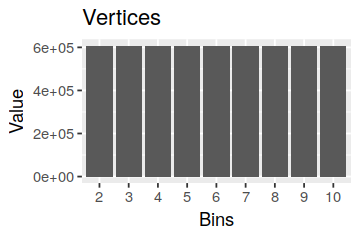

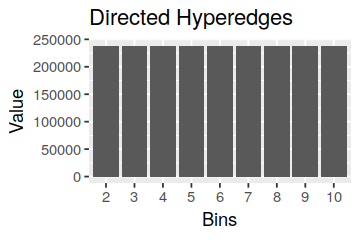

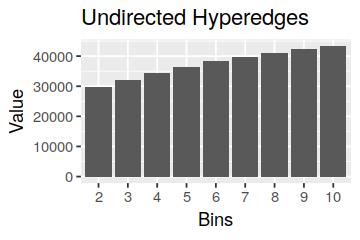

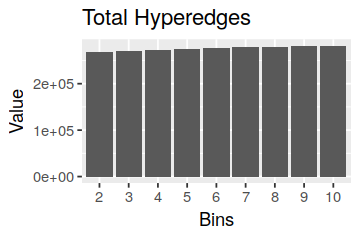

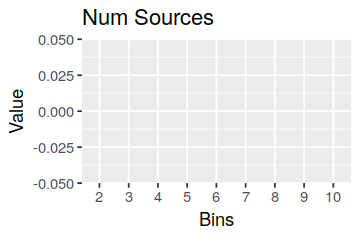

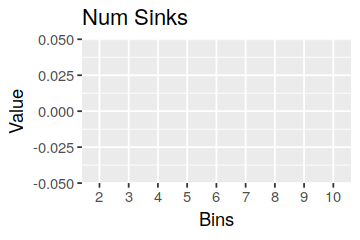

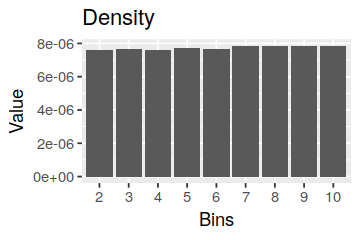

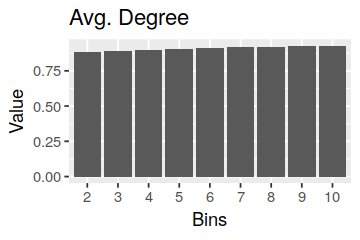

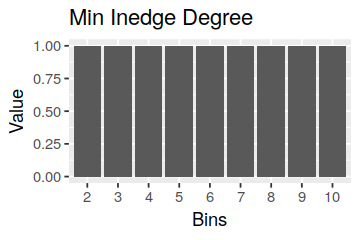

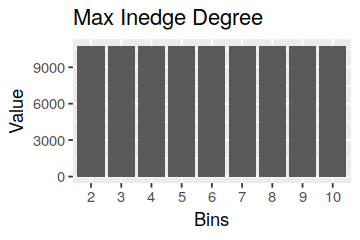

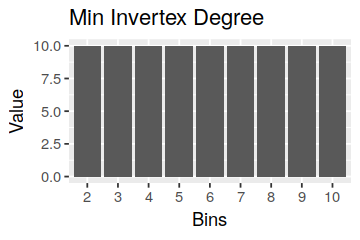

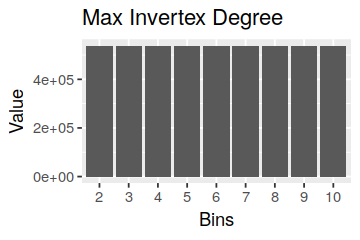

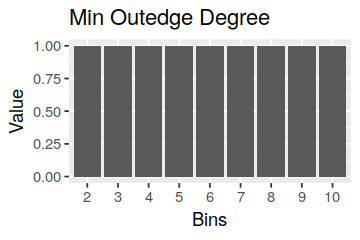

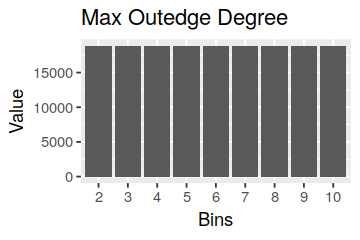

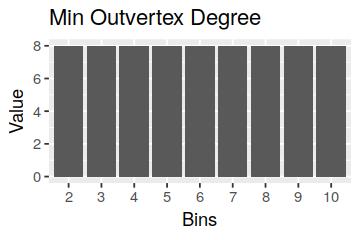

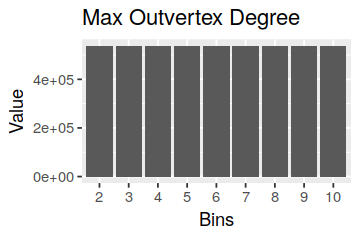

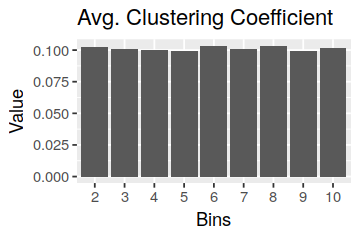

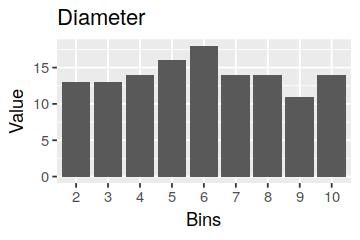

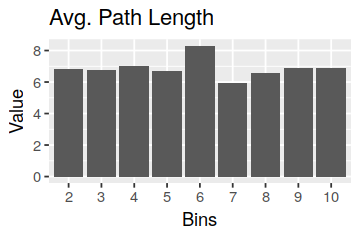

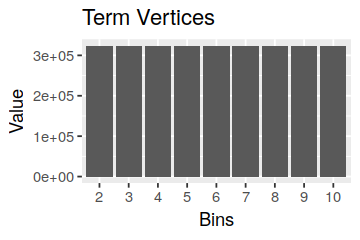

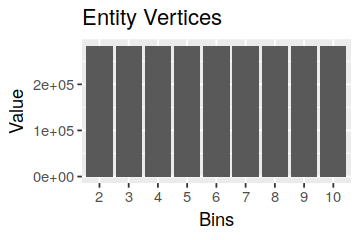

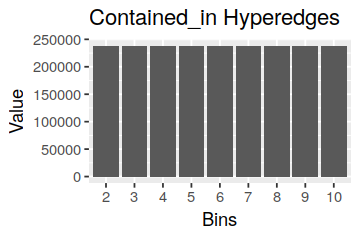

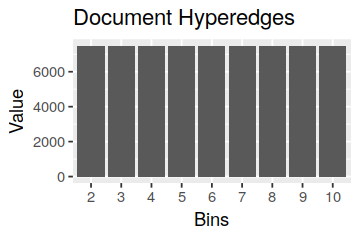

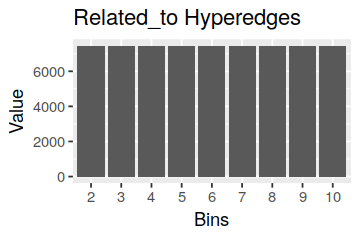

In [659]:
options(repr.plot.width=3, repr.plot.height=2)
for (stat_name in unique(stats$Statistic)) {
    print(plot_stat(stats, stat_name))
}

## Scalability

In order to better understand the impact of adding more documents and entities to the index, we created several snapshots by limiting the number of documents read from INEX 2009 3T-NL subset test collection. We then obtained the following aggregated statistics from each snapshot studying their evolution for an increasing number of documents:

- Average node degree;
 - Average node incoming edge degree;
 - Average node outgoing edge degree;
 - Average node incoming node degree;
 - Average node outgoing node degree;
- Average hyperedge cardinality;
 - Average cardinality for undirected hyperedges;
 - Average tail cardinality for directed hyperedges;
 - Average head cardinality for directed hyperedges;
- Estimated clustering coefficient;
- Estimated average path length and diameter;
- General mixed hypergraph density;
- Size and space usage;
 - Number of nodes;
 - Number of hyperedges;
 - Number of bytes in disk;
 - Number of bytes in memory.

We will begin by the node and hyperedge degree. In order to generate the required data, run the scripts in `runs/inex-2009-3t-nl/hgoe/scalability` in order. This will generate indices with a progressively larger number of documents, using the `--limit` argument (snapshots). Inspect will then generate the node and edge degree distributions per index snapshot, properly organizing them in a directory with name `snapshot_<id>_<num_docs>`.

In [354]:
options(repr.plot.width=4, repr.plot.height=2)

In [355]:
load_snapshots_degree_data <- function(base_dir, type="node") {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            do.call(
                paste("load", type, ifelse(type == "node", "degree", "cardinality"), "data", sep="_"),
                list(base_dir = snapshot_dir)))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    data
}

In [359]:
snapshot_node_degree <- bind_rows(
    lapply(bin_dirs, function(bin_dir) {
        cbind(bin_id=bin_dir, load_snapshots_degree_data(file.path(base_dir, bin_dir, "snapshots"), type="node"))
    })
)
head(snapshot_node_degree)

bin_id,snapshot_name,snapshot_id,num_docs,node_id,type,name,v_degree,e_degree,in_v_degree,out_v_degree,in_e_degree,out_e_degree,dir_in_v_degree,dir_out_v_degree,dir_in_e_degree,dir_out_e_degree
<chr>,<fct>,<fct>,<dbl>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
bins_02,snapshot_001_1,001,1,0,entity,"Cochrane, Wisconsin",123,3,123,123,3,2,1,0,1,0
bins_02,snapshot_001_1,001,1,1,entity,Zefram Cochrane,123,3,123,123,3,2,1,0,1,0
bins_02,snapshot_001_1,001,1,2,entity,Alexander Cochrane,123,2,123,123,2,2,0,0,0,0
bins_02,snapshot_001_1,001,1,3,entity,Warp drive,123,3,123,123,3,2,2,0,1,0
bins_02,snapshot_001_1,001,1,4,entity,Cochrane River,123,3,123,123,3,2,1,0,1,0
bins_02,snapshot_001_1,001,1,5,entity,War of 1812,123,3,123,123,3,2,2,0,1,0


In [360]:
snapshot_edge_degree <- bind_rows(
    lapply(bin_dirs, function(bin_dir) {
        cbind(bin_id=bin_dir, load_snapshots_degree_data(file.path(base_dir, bin_dir, "snapshots"), type="edge"))
    })
)
head(snapshot_edge_degree)

bin_id,snapshot_name,snapshot_id,num_docs,edge_id,type,is_directed,cardinality,undirected_cardinality,tail_cardinality,head_cardinality
<chr>,<fct>,<fct>,<dbl>,<int>,<chr>,<lgl>,<int>,<int>,<int>,<int>
bins_02,snapshot_001_1,001,1,0,document,FALSE,123,123,0,0
bins_02,snapshot_001_1,001,1,1,related_to,FALSE,28,28,0,0
bins_02,snapshot_001_1,001,1,2,tf_bin,FALSE,80,80,0,0
bins_02,snapshot_001_1,001,1,3,tf_bin,FALSE,14,14,0,0
bins_02,snapshot_001_1,001,1,4,contained_in,TRUE,2,0,1,1
bins_02,snapshot_001_1,001,1,5,contained_in,TRUE,2,0,1,1


In [649]:
plot_degree_over_time <- function(data, label, stat="degree") {
    data <- data %>%
        group_by(bin_id, num_docs) %>%
        summarize(mean=mean(!!sym(stat), na.rm=TRUE)) %>%
        mutate(bins=factor(as.integer(str_split(bin_id, "_", simplify = TRUE)[, 2]), levels = 2:10))

    ggplot(data, aes(x=num_docs, y=mean, color=bins)) +
        geom_line() +
        scale_color_discrete("Bins") +
        xlab("Number of Documents") +
        ylab(label) +
        theme(
            legend.position = c(0.9925, 0.175),
            legend.direction = "horizontal",
            legend.justification = "right") +
        guides(
            color = guide_legend(
                nrow = 1,
                byrow = TRUE,
                title.position = "top",
                keywidth = 0.6,
                keyheight = 0.6,
            title.theme = element_text(size=8)))
}
                      
plot_size_over_time <- function(data, label, stat="degree") {
    data <- data %>%
        group_by(bin_id, num_docs) %>%
        summarize(len=length(!!sym(stat))) %>%
        mutate(bins=factor(as.integer(str_split(bin_id, "_", simplify = TRUE)[, 2]), levels = 2:10))

    ggplot(data, aes(x=num_docs, y=len, color=bins)) +
        geom_line() +
        scale_color_discrete() +
        xlab("Number of Documents") +
        ylab(label) +
        theme(
            legend.position = c(0.9925, 0.175),
            legend.direction = "horizontal",
            legend.justification = "right") +
        guides(
            color = guide_legend(
                nrow = 1,
                byrow = TRUE,
                title.position = "top",
                keywidth = 0.6,
                keyheight = 0.6,
            title.theme = element_text(size=8)))
}

### Average node degree

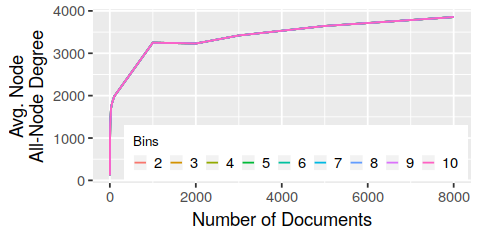

In [607]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node\nAll-Node Degree", stat = "v_degree")
ggsave(filename = "output/tf_bins/snapshot_average_all_node_degree.png", width = 4, height = 2, dpi = 300)

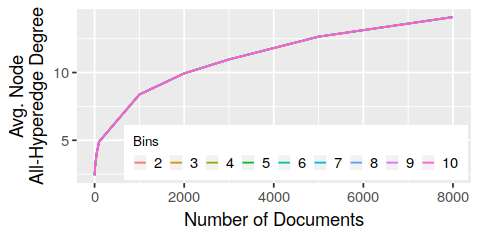

In [608]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node\nAll-Hyperedge Degree", stat = "e_degree")
ggsave(filename = "output/tf_bins/snapshot_average_all_hyperedge_degree.png", width = 4, height = 2, dpi = 300)

#### Average node degree based on directed hyperedges

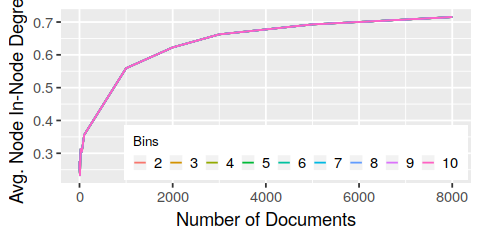

In [570]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node In-Node Degree", stat = "dir_in_v_degree")

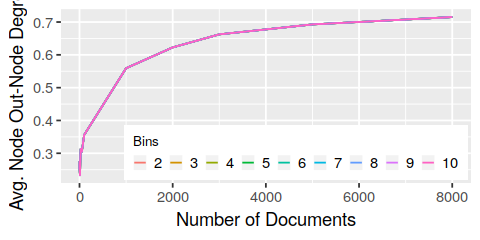

In [571]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node Out-Node Degree", stat = "dir_out_v_degree")

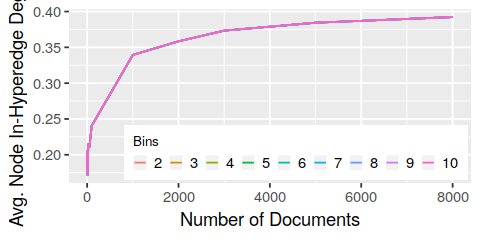

In [572]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node In-Hyperedge Degree", stat = "dir_in_e_degree")

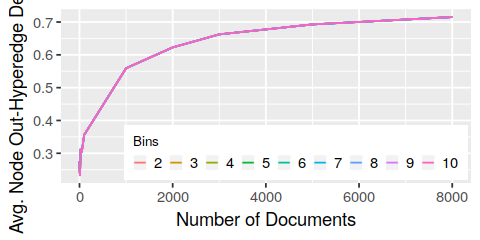

In [573]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node Out-Hyperedge Degree", stat = "dir_out_e_degree")

### Average hyperedge cardinality

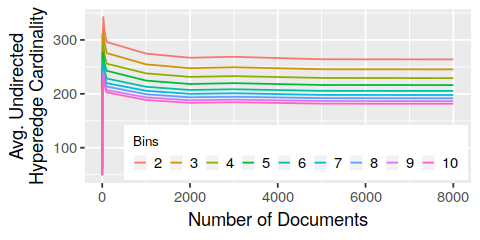

In [574]:
plot_degree_over_time(
    snapshot_edge_degree %>% filter(!is_directed), "Avg. Undirected\nHyperedge Cardinality", stat = "cardinality")
ggsave(filename = "output/tf_bins/snapshot_average_hyperedge_cardinality.png", width = 4, height = 2, dpi = 300)

In [575]:
snapshot_edge_degree %>%
    filter(!is_directed) %>%
    group_by(num_docs) %>%
    summarise(mean=mean(cardinality, na.rm = TRUE))

num_docs,mean
<dbl>,<dbl>
1,55.1250
2,241.0645
3,219.5455
4,180.3034
5,223.9200
10,229.8039
25,268.9634
50,249.9864
100,234.2748


#### Average directed hyperedge cardinalities

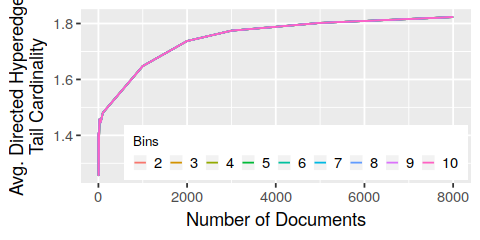

In [576]:
plot_degree_over_time(
    snapshot_edge_degree %>% filter(is_directed),
    "Avg. Directed Hyperedge\nTail Cardinality",
    stat = "tail_cardinality")

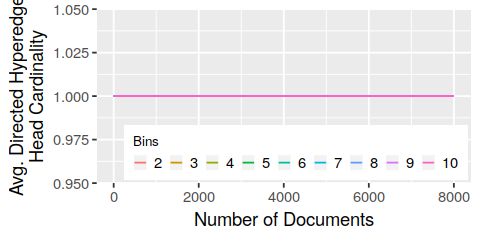

In [577]:
plot_degree_over_time(
    snapshot_edge_degree %>% filter(is_directed),
    "Avg. Directed Hyperedge\nHead Cardinality",
    stat = "head_cardinality")

### Estimated clustering coefficient

In [372]:
load_snapshots_stats_data <- function(base_dir) {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            do.call("load_stats_data", list(base_dir = snapshot_dir)))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    
    setNames(data, c(names(data)[1:3], "statistic", "value"))
}

In [581]:
snapshot_stats <- bind_rows(
    lapply(bin_dirs, function(bin_dir) {
        cbind(bin_id=bin_dir, load_snapshots_stats_data(file.path(base_dir, bin_dir, "snapshots")))
    })
)
head(snapshot_stats)

bin_id,snapshot_name,snapshot_id,num_docs,statistic,value
<chr>,<fct>,<fct>,<dbl>,<chr>,<dbl>
bins_02,snapshot_001_1,001,1,Vertices,123
bins_02,snapshot_001_1,001,1,Directed Hyperedges,22
bins_02,snapshot_001_1,001,1,Undirected Hyperedges,4
bins_02,snapshot_001_1,001,1,Total Hyperedges,26
bins_02,snapshot_001_1,001,1,Num Sources,0
bins_02,snapshot_001_1,001,1,Num Sinks,0


In [634]:
plot_statistics_over_time <- function(data, label, log_scale=FALSE, legend_position = c(0.565, 0.8)) {
    data <- data %>%
        mutate(bins=factor(as.integer(str_split(bin_id, "_", simplify = TRUE)[, 2]), levels = 2:10))
    
    if (length(unique(data$statistic)) > 1) {
        p <- ggplot(data, aes(x=num_docs, y=value, color=bins)) +
            facet_wrap(~statistic)
    } else {
        p <- ggplot(data, aes(x=num_docs, y=value, color=bins))
    }
    
    if (log_scale) {
        p <- p + scale_x_log10() + scale_y_log10()
    }
    
    p + geom_line() +
        xlab("Number of Documents") +
        ylab(label) +
        theme(
            legend.position = "top",
            legend.direction = "horizontal") +
        guides(
            color = guide_legend(
                nrow = 1,
                byrow = TRUE,
                keywidth = 0.6,
                keyheight = 0.6,
            title.theme = element_text(size=8)))
}

In [635]:
snapshot_cc <- snapshot_stats[which(snapshot_stats$statistic == "Avg. Clustering Coefficient"), ]
snapshot_cc

,bin_id,snapshot_name,snapshot_id,num_docs,statistic,value
,<chr>,<fct>,<fct>,<dbl>,<chr>,<dbl>
17,bins_02,snapshot_001_1,001,1,Avg. Clustering Coefficient,0.5299007
36,bins_02,snapshot_002_2,002,2,Avg. Clustering Coefficient,0.4304082
55,bins_02,snapshot_003_3,003,3,Avg. Clustering Coefficient,0.4367351
74,bins_02,snapshot_004_4,004,4,Avg. Clustering Coefficient,0.4358793
93,bins_02,snapshot_005_5,005,5,Avg. Clustering Coefficient,0.4000009
112,bins_02,snapshot_006_10,006,10,Avg. Clustering Coefficient,0.3723298
131,bins_02,snapshot_007_25,007,25,Avg. Clustering Coefficient,0.3266924
150,bins_02,snapshot_008_50,008,50,Avg. Clustering Coefficient,0.2708532
169,bins_02,snapshot_009_100,009,100,Avg. Clustering Coefficient,0.2236981


In [636]:
options(repr.plot.width=4, repr.plot.height=2.5)

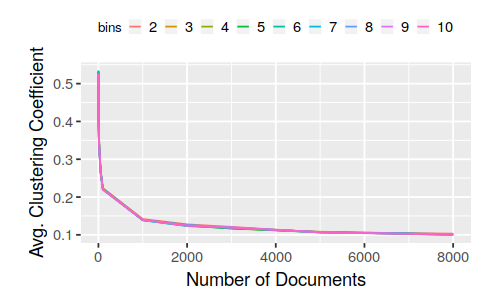

In [637]:
plot_statistics_over_time(snapshot_cc, "\nAvg. Clustering Coefficient")
ggsave(filename = "output/tf_bins/snapshot_avg_clustering_coefficient.png", width = 4, height = 2.5, dpi = 300)

### Estimated average path length and diameter

In [638]:
snapshot_paths <- snapshot_stats[which(snapshot_stats$statistic %in% c("Avg. Path Length", "Diameter")), ]
snapshot_paths %>% filter(statistic == "Diameter")
snapshot_paths %>% filter(statistic == "Avg. Path Length")

bin_id,snapshot_name,snapshot_id,num_docs,statistic,value
<chr>,<fct>,<fct>,<dbl>,<chr>,<dbl>
bins_02,snapshot_001_1,001,1,Diameter,341
bins_02,snapshot_002_2,002,2,Diameter,6
bins_02,snapshot_003_3,003,3,Diameter,8
bins_02,snapshot_004_4,004,4,Diameter,9
bins_02,snapshot_005_5,005,5,Diameter,7
bins_02,snapshot_006_10,006,10,Diameter,11
bins_02,snapshot_007_25,007,25,Diameter,10
bins_02,snapshot_008_50,008,50,Diameter,18
bins_02,snapshot_009_100,009,100,Diameter,15


bin_id,snapshot_name,snapshot_id,num_docs,statistic,value
<chr>,<fct>,<fct>,<dbl>,<chr>,<dbl>
bins_02,snapshot_001_1,001,1,Avg. Path Length,148.266660
bins_02,snapshot_002_2,002,2,Avg. Path Length,3.700000
bins_02,snapshot_003_3,003,3,Avg. Path Length,4.100000
bins_02,snapshot_004_4,004,4,Avg. Path Length,3.966667
bins_02,snapshot_005_5,005,5,Avg. Path Length,3.933333
bins_02,snapshot_006_10,006,10,Avg. Path Length,4.433333
bins_02,snapshot_007_25,007,25,Avg. Path Length,5.733333
bins_02,snapshot_008_50,008,50,Avg. Path Length,6.400000
bins_02,snapshot_009_100,009,100,Avg. Path Length,6.400000


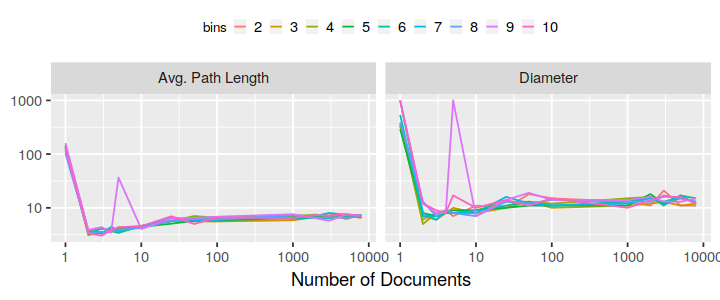

In [639]:
options(repr.plot.width=6, repr.plot.height=2.5)
plot_statistics_over_time(snapshot_paths, NULL, log_scale = TRUE)
ggsave(filename = "output/tf_bins/snapshot_avg_shortest_path_stats.png", width = 8, height = 2.5, dpi = 300)

### General mixed hypergraph density

In [647]:
snapshot_density <- snapshot_stats[which(snapshot_stats$statistic == "Density"), ]
head(snapshot_density)

,bin_id,snapshot_name,snapshot_id,num_docs,statistic,value
,<chr>,<fct>,<fct>,<dbl>,<chr>,<dbl>
7,bins_02,snapshot_001_1,001,1,Density,1.700526e-03
26,bins_02,snapshot_002_2,002,2,Density,1.444243e-04
45,bins_02,snapshot_003_3,003,3,Density,1.091795e-04
64,bins_02,snapshot_004_4,004,4,Density,9.908161e-05
83,bins_02,snapshot_005_5,005,5,Density,6.671113e-05
102,bins_02,snapshot_006_10,006,10,Density,3.543885e-05


In [645]:
options(repr.plot.width=4, repr.plot.height=2.5)

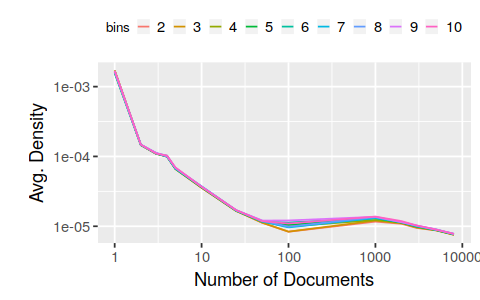

In [646]:
plot_statistics_over_time(snapshot_density, "\nAvg. Density", log_scale = TRUE)
ggsave(filename = "output/tf_bins/snapshot_avg_density.png", width = 4, height = 2, dpi = 300)

### Size and space usage

#### Number of nodes and hyperedges

The growth in number of nodes is sublinear in regard to the number of documents.

In [648]:
snapshot_node_degree %>%
        group_by(bin_id, num_docs) %>%
        summarize(len=length(node_id)) %>%
        head()

bin_id,num_docs,len
<chr>,<dbl>,<int>
bins_02,1,123
bins_02,2,1217
bins_02,3,1559
bins_02,4,1702
bins_02,5,2497
bins_02,10,4566


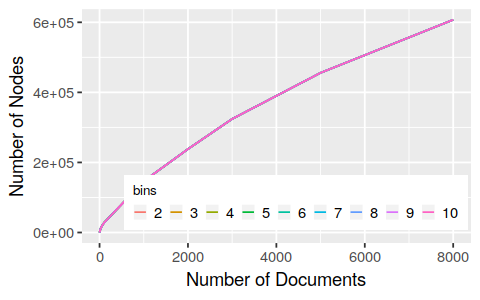

In [650]:
plot_size_over_time(snapshot_node_degree, "Number of Nodes", stat = "node_id")
ggsave(filename = "output/tf_bins/snapshot_num_nodes.png", width = 4.5, height = 2, dpi = 300)

Similarly, the growth in number of hyperedges is sublinear in regard to the number of documents, although there are significantly less hyperedges than nodes.

In [651]:
snapshot_edge_degree %>%
        group_by(num_docs) %>%
        summarize(len=length(edge_id))

num_docs,len
<dbl>,<int>
1,238
2,2343
3,2931
4,3184
5,4545
10,7506
25,23799
50,36025
100,64231


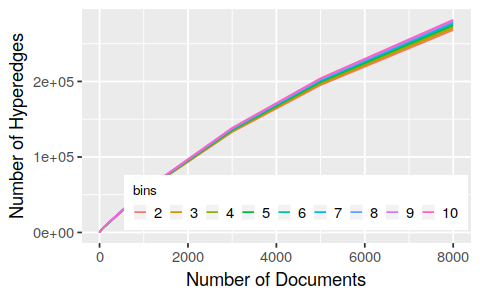

In [652]:
plot_size_over_time(snapshot_edge_degree, "Number of Hyperedges", stat = "edge_id")
ggsave(filename = "output/tf_bins/snapshot_num_hyperedges.png", width = 4.5, height = 2, dpi = 300)

#### Number of bytes in disk and memory

In [653]:
load_snapshots_space_usage_data <- function(base_dir) {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            read.csv(file.path(snapshot_dir, list.files(path = snapshot_dir, pattern = "space-usage-.*\\.csv"))))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    data
}

In [655]:
snapshot_space <- bind_rows(
    lapply(bin_dirs, function(bin_dir) {
        cbind(bin_id=bin_dir, load_snapshots_space_usage_data(file.path(base_dir, bin_dir, "snapshots")))
    })
)
head(snapshot_space)

bin_id,snapshot_name,snapshot_id,num_docs,Statistic,Value
<chr>,<fct>,<fct>,<dbl>,<fct>,<dbl>
bins_02,snapshot_001_1,001,1,Disk (Bytes),44051
bins_02,snapshot_001_1,001,1,Memory (Bytes),741553776
bins_02,snapshot_002_2,002,2,Disk (Bytes),290291
bins_02,snapshot_002_2,002,2,Memory (Bytes),741684360
bins_02,snapshot_003_3,003,3,Disk (Bytes),366975
bins_02,snapshot_003_3,003,3,Memory (Bytes),822084176


In [657]:
snapshot_space %>%
    filter(Statistic == "Disk (Bytes)") %>%
    group_by(bin_id) %>%
    summarise(Mean=mean(Value), StdDev=sd(Value)) %>%
    mutate(Mean=paste(round(Mean / 1024^2, 1), "MiB"), StdDev=paste(round(StdDev / 1024^2, 1), "MiB"))

snapshot_space %>%
    filter(Statistic == "Memory (Bytes)") %>%
    group_by(bin_id) %>%
    summarise(Mean=mean(Value), StdDev=sd(Value)) %>%
    mutate(Mean=paste(round(Mean / 1024^3, 1), "GiB"), StdDev=paste(round(StdDev / 1024^2, 1), "MiB"))

bin_id,Mean,StdDev
<chr>,<chr>,<chr>
bins_02,39.8 MiB,63.2 MiB
bins_03,39.9 MiB,63.4 MiB
bins_04,40 MiB,63.5 MiB
bins_05,40.1 MiB,63.7 MiB
bins_06,40.1 MiB,63.8 MiB
bins_07,40.2 MiB,63.9 MiB
bins_08,40.2 MiB,63.9 MiB
bins_09,40.3 MiB,64 MiB
bins_10,40.3 MiB,64.1 MiB


bin_id,Mean,StdDev
<chr>,<chr>,<chr>
bins_02,1 GiB,466.5 MiB
bins_03,1 GiB,468.3 MiB
bins_04,1 GiB,466.7 MiB
bins_05,1 GiB,474.6 MiB
bins_06,1 GiB,467.9 MiB
bins_07,1 GiB,459.3 MiB
bins_08,1 GiB,472.1 MiB
bins_09,1 GiB,470.1 MiB
bins_10,1 GiB,468.4 MiB


In [680]:
plot_space_usage <- function(data, label, stat = "Disk (Bytes)", unit="MB") {
    data <- data %>%
        filter(Statistic == stat) %>%
        mutate(bins=factor(as.integer(str_split(bin_id, "_", simplify = TRUE)[, 2]), levels = 2:10))
    
    stopifnot(unit %in% c("B", "KB", "MB", "GB", "TB"))
    
    if (unit == "B") {
        frac <- 1
    } else if (unit == "KB") {
        frac <- 1024
    } else if (unit == "MB") {
        frac <- 1024^2
    } else if (unit == "GB") {
        frac <- 1024^3
    } else if (unit == "TB") {
        frac <- 1024^4
    }
    
    ggplot(data, aes(x = num_docs, y = Value / frac, color=bins)) +
        geom_line() +
        scale_y_continuous(label = function(s) paste(s, unit)) +
        xlab("Number of Documents") +
        ylab(label) +
        theme(
            legend.position = "top",
            legend.direction = "horizontal") +
        guides(
            color = guide_legend(
                nrow = 1,
                byrow = TRUE,
                keywidth = 0.6,
                keyheight = 0.6,
            title.theme = element_text(size=8)))
}

The growth in disk space is sublinear in regard to the number of documents.

In [683]:
options(repr.plot.width=4, repr.plot.height=2.5)

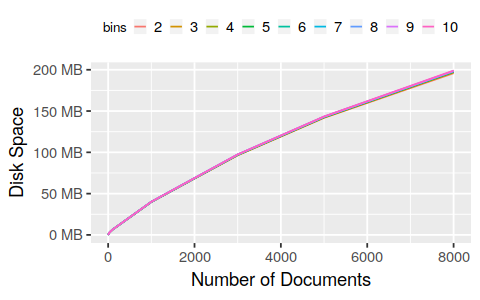

In [684]:
plot_space_usage(snapshot_space, "Disk Space", stat = "Disk (Bytes)")
ggsave(filename = "output/tf_bins/snapshot_disk_space.png", width = 4.5, height = 2, dpi = 300)

The growth in memory space is sublinear in regard to the number of documents, presenting a sharper growth for the first 1000 documents.

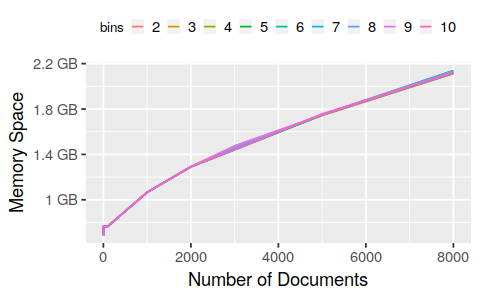

In [685]:
plot_space_usage(snapshot_space, "Memory Space", stat = "Memory (Bytes)", unit = "GB")
ggsave(filename = "output/tf_bins/snapshot_mem_space.png", width = 4.5, height = 2, dpi = 300)